# SUMMARY

This notebook demonstrates how to compute mean and standard deviation of training and test images using PyTorch. Knowing mean and STD may be helpful for normalizing images within the augmentation pipeline. While computing mean is easy (we can simply average it over batches), standard deviation is a bit more tricky: averaging STDs across batches is not the same as the overall STD. Let's see how to do it properly!


### TL;DR

- train images: `mean = 0.9871, std = 0.0888`
- test images:  `mean = 0.9863, std = 0.0921`

# PREPARATIONS

First, we import the usuall libraries and specify relevant parameters. No need to use GPU because there is no modeling involved.

In [1]:
####### PACKAGES

import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
####### PARAMS

device      = torch.device('cpu') 
num_workers = 4
batch_size  = 128
image_size  = 224
data_path   = '/kaggle/input/bms-molecular-translation/'

# DATA PREP

Now, let's set up a Dataset and a Dataloader.

In [3]:
###### DATA IMPORT

df = pd.read_csv(data_path + 'train_labels.csv')

def get_train_file_path(image_id):
    return data_path + 'train/{}/{}/{}/{}.png'.format(image_id[0], image_id[1], image_id[2], image_id)

df['file_path'] = df['image_id'].apply(get_train_file_path)
df.head()

,image_id,InChI,file_path
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,/kaggle/input/bms-molecular-translation/train/...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,/kaggle/input/bms-molecular-translation/train/...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,/kaggle/input/bms-molecular-translation/train/...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,/kaggle/input/bms-molecular-translation/train/...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,/kaggle/input/bms-molecular-translation/train/...


In [4]:
####### DATASET

class ImageData(Dataset):
    
    def __init__(self, df, transform):
        super().__init__()
        self.df         = df
        self.file_paths = df['file_path'].values
        self.transform  = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        # import
        file_path = self.file_paths[idx]        
        image     = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) 
        if image is None:
            raise FileNotFoundError(file_path)
            
        # augmentations
        if self.transform:
            image = self.transform(image = image)['image']
            
        return image

Our augmentation pipeline uses `A.Normalize()` with mean = 0 and std = 1 to scale pixel values from `[0, 255]` to `[0, 1]`.

In [5]:
##### AUGMENTATIONS

augs = A.Compose([A.Resize(height  = image_size, 
                           width   = image_size),
                  A.Normalize(mean = (0), 
                              std  = (1)),
                  ToTensorV2()])

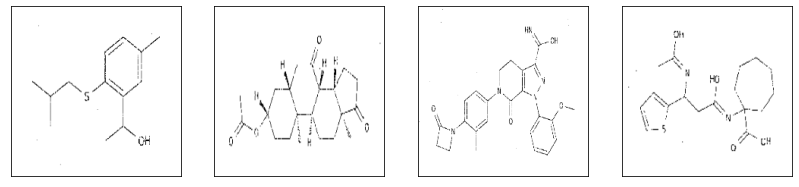

In [6]:
####### EXAMINE SAMPLE BATCH

# dataset
image_dataset = ImageData(df        = df, 
                          transform = augs)

# data loader
image_loader = DataLoader(image_dataset, 
                          batch_size  = batch_size, 
                          shuffle     = False, 
                          num_workers = num_workers)

# display images
for batch_idx, inputs in enumerate(image_loader):
    fig = plt.figure(figsize = (14, 7))
    for i in range(4):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy()[0, :, :], cmap = 'gray')
    break

# CALCULATIONS

The calculations are done in three steps:

1. Define placeholders to store two batch-level stats: sum and squared sum of pixel values. The first will be used to compute the mean, and the latter will be needed for standard deviation calculations.
2. Loop through the batches and add up sum and squared sum values.
3. Perform final calculations to obtain data-level mean and standard deviation.

## Training images

In [7]:
##### COMPUTE PIXEL SUM AND SQUARED SUM

# placeholders
psum    = torch.tensor([0.0])
psum_sq = torch.tensor([0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

100%|██████████| 18939/18939 [1:27:17<00:00,  3.62it/s]


- to get the mean, we simply divide the sum of pixel values by `count` - the total number of pixels in the dataset computed as `len(df) * image_size * image_size`.
- to get the standard deviation, we use the following equation: `total_std = sqrt(psum_sq / count - total_mean ** 2)`. Why is that so? Well, because this is how the variance equation can be simplified to make use of the sum of squares. If you are not sure about this, feel free to check out [this link](https://www.thoughtco.com/sum-of-squares-formula-shortcut-3126266) for some details.

![variance equation](https://kozodoi.me/images/copied_from_nb/images/fig_variance.jpg)

In [8]:
##### FINAL CALCULATIONS

# pixel count
count = len(df) * image_size * image_size

# mean and STD
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('Training data stats:')
print('- mean: {:.4f}'.format(total_mean.item()))
print('- std:  {:.4f}'.format(total_std.item()))

Training data stats:
- mean: 0.9871
- std:  0.0888


## Test images

In [9]:
###### DATA IMPORT

df = pd.read_csv(data_path + 'sample_submission.csv')

def get_test_file_path(image_id):
    return data_path + 'test/{}/{}/{}/{}.png'.format(image_id[0], image_id[1], image_id[2], image_id)

df['file_path'] = df['image_id'].apply(get_test_file_path)
df.head()

,image_id,InChI,file_path
0,00000d2a601c,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/0...
1,00001f7fc849,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/0...
2,000037687605,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/0...
3,00004b6d55b6,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/0...
4,00004df0fe53,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/0...


In [10]:
###### DATASET & DATALOADER

# dataset
image_dataset = ImageData(df        = df, 
                          transform = augs)

# data loader
image_loader = DataLoader(image_dataset, 
                          batch_size  = batch_size, 
                          shuffle     = False, 
                          num_workers = num_workers)

In [11]:
##### CALCULATIONS

# placeholders
psum    = torch.tensor([0.0])
psum_sq = torch.tensor([0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])
    
# pixel count
count = len(df) * image_size * image_size

# mean and STD
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('Test data stats:')
print('- mean: {:.4f}'.format(total_mean.item()))
print('- std:  {:.4f}'.format(total_std.item()))

100%|██████████| 12626/12626 [1:04:32<00:00,  3.26it/s]


Test data stats:
- mean: 0.9863
- std:  0.0921


If you use a different image size, you can simply update this parameter to make sure calculations are done appropriately. Good luck!